<a href="https://colab.research.google.com/github/sujinee01/Capstone/blob/main/0%EB%8F%84_all_cycle_tcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 라이브러리**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.preprocessing.sequence import pad_sequences

Mounted at /content/drive


In [ ]:
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
# Min-Max 스케일러 인스턴스 생성
scaler = MinMaxScaler()

# **1. 데이터 정제**

결측치 처리, 이상치 제거, 데이터 타입 변환 등 데이터를 분석에 적합한 형태로 정제합니다.

In [ ]:
# 데이터 정제 함수
def preprocess_excel(file_path):
    # 엑셀 파일 로드
    df = pd.read_excel(file_path)

    # 불필요한 열 제거
    df.drop(columns=['Step_Time(s)','Step_Index','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10'], inplace=True)

    # 결측치가 있는 행 제거
    df.dropna(inplace=True)

    return df

In [ ]:
# Driving_Cycle 특성 추가 함수
import re

#파일 이름에서 정보 추출하는 함수 정의
def extract_info_from_filename(filename):
    # Driving Cycle과 온도 정보를 추출하는 정규 표현식
    pattern = r'LiFePO4_(\w+)_SOC_(-?\d+)_'
    match = re.search(pattern, filename)
    if match:
        Driving_Cycle = match.group(1)
        temperature = int(match.group(2))
        return Driving_Cycle, temperature
    else:
        return None, None

# Driving_Cycle을 정수형으로 반환하는 함수
def Driving_Cycle_Numb(Driving_Cycle):
  if Driving_Cycle=='DST':
    Numb=1
    return Numb
  elif Driving_Cycle=='FUDS':
    Numb=2
    return Numb
  elif Driving_Cycle=='US06':
    Numb=3
    return Numb

In [ ]:
def process_all_files(folder_path):
    # 모든 엑셀 파일 목록 가져오기
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

    # 파일 목록을 원하는 순서로 정렬

    # 모든 파일에 대해 전처리 수행
    processed_dfs = []
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)

        # 불필요한 열, 결측치 행 제거
        processed_df = preprocess_excel(file_path)

        # 차분 : 비정상 시계열 -> 정상시계열
        result = adfuller(processed_df['SOC(t)'])
        processed_df['SOC(t)_diff'] = processed_df['SOC(t)'].diff()
        processed_df['SOC(t)_diff'][0]=processed_df['SOC(t)_diff'][1] # NaN 값 대체

        # 주행 사이클, 온도 열 추가
        Driving_Cycle, temperature = extract_info_from_filename(file_name)
        processed_df['Driving_Cycle']= Driving_Cycle_Numb(Driving_Cycle)

        processed_dfs.append(processed_df)

    return processed_dfs

In [ ]:
folder_path = '/content/drive/MyDrive/LiFePO4_Dynamic_Profile_Files/LiFePO4 Dynamic Profile Files/All_temp_cycle'
all_processed_data = process_all_files(folder_path)

In [ ]:
all_processed_data

[      Test_Time(s)  Current(A)  Voltage(V)  Temperature (C)_1     SOC(t)  \
 0     18404.143073    0.000000    3.537362           0.142000  80.000000   
 1     18405.145342   -0.000451    3.537054           0.217861  80.000000   
 2     18406.150476   -0.000271    3.537054           0.324691  79.999989   
 3     18407.156485   -0.000451    3.536747           0.142000  79.999983   
 4     18408.156485   -0.000271    3.536439           0.142000  79.999972   
 ...            ...         ...         ...                ...        ...   
 6289  24710.496901   -0.885938    2.510331           1.058758   0.230413   
 6290  24711.499968   -0.892615    2.507253           1.058758   0.209186   
 6291  24712.501005   -3.029550    2.029593           1.058758   0.187798   
 6292  24713.502010   -1.062964    2.429695           1.058758   0.115209   
 6293  24714.249121   -3.745411    1.919104           0.831143   0.089740   
 
       SOC(t)_diff  Driving_Cycle  
 0        0.000000              3  
 1

In [ ]:
type(all_processed_data)

list

# **3. 특성 엔지니어링 및 전처리**

# **2. 탐색적 데이터 분석(EDA)**

**-시각화** : 시계열 데이터의 추세(trend), 계절성(seasonality), 순환성(cyclic) 등을 파악하기 위해 시각화를 수행합니다.

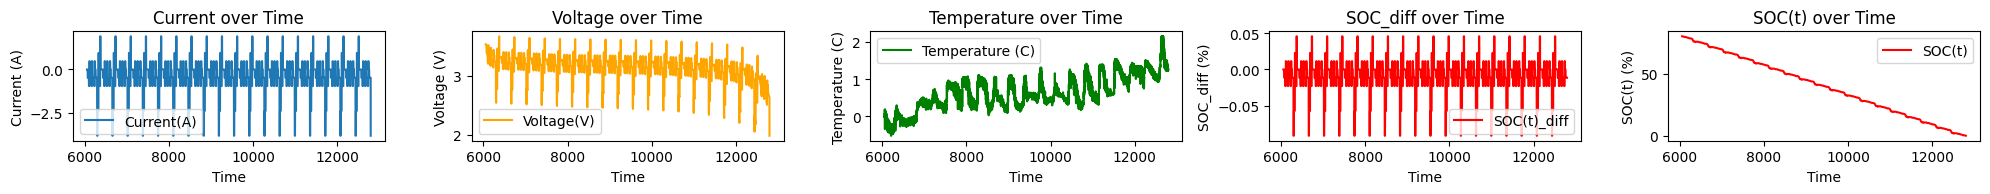

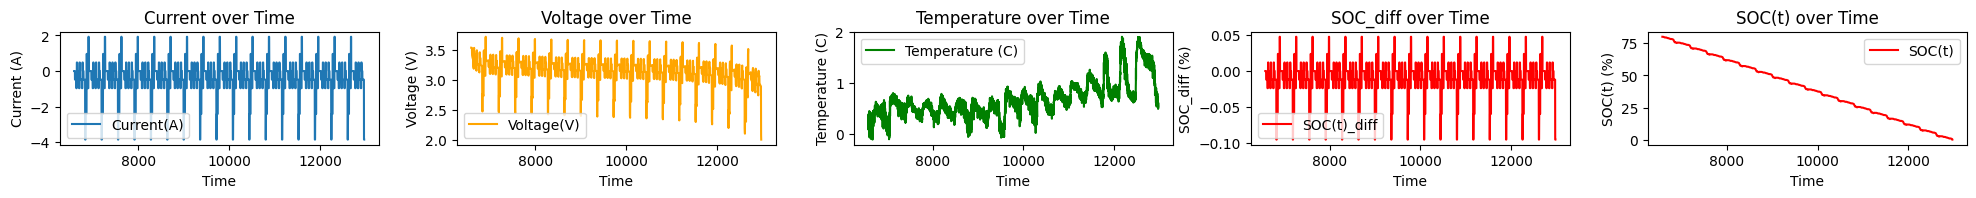

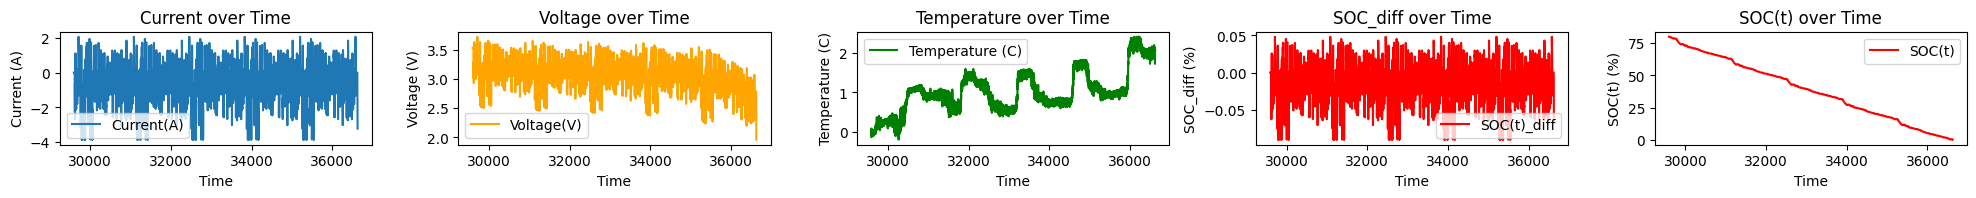

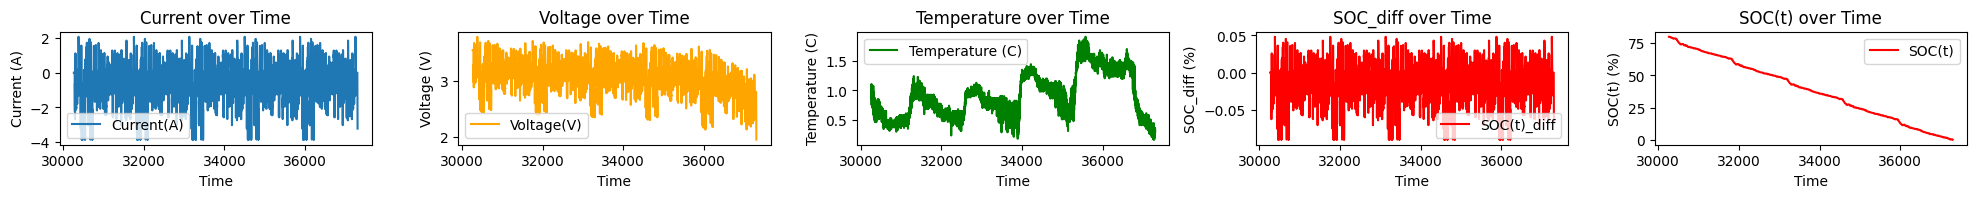

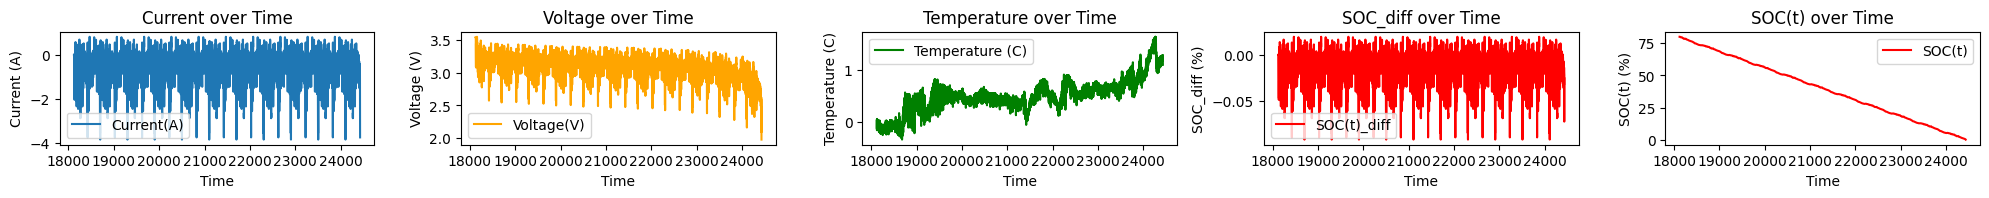

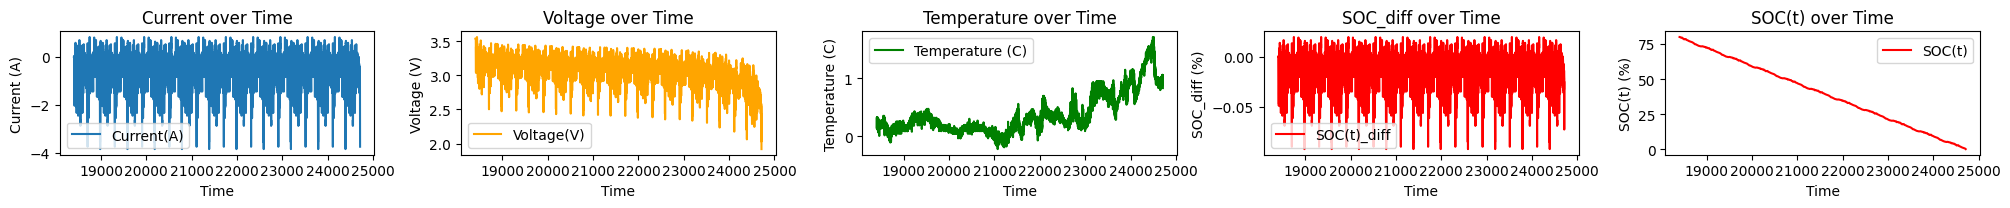

In [ ]:
# 시각화를 위한 데이터 준비
i=1
for df in all_processed_data:
  time_column = df['Test_Time(s)']
  current = df['Current(A)']
  voltage = df['Voltage(V)']
  temperature = df['Temperature (C)_1']
  soc_diff = df['SOC(t)_diff']
  soc = df['SOC(t)']

  # 각 값에 대한 시간 변화를 선 그래프로 시각화
  plt.figure(figsize=(20, 10))

  plt.subplot(6, 5, i)
  plt.plot(time_column, current, label='Current(A)')
  plt.xlabel('Time')
  plt.ylabel('Current (A)')
  plt.title('Current over Time')
  plt.legend()

  plt.subplot(6, 5, i+1)
  plt.plot(time_column, voltage, label='Voltage(V)', color='orange')
  plt.xlabel('Time')
  plt.ylabel('Voltage (V)')
  plt.title('Voltage over Time')
  plt.legend()

  plt.subplot(6, 5, i+2)
  plt.plot(time_column, temperature, label='Temperature (C)', color='green')
  plt.xlabel('Time')
  plt.ylabel('Temperature (C)')
  plt.title('Temperature over Time')
  plt.legend()

  plt.subplot(6, 5, i+3)
  plt.plot(time_column, soc_diff, label='SOC(t)_diff', color='red')
  plt.xlabel('Time')
  plt.ylabel('SOC_diff (%)')
  plt.title('SOC_diff over Time')
  plt.legend()

  plt.subplot(6, 5, i+4)
  plt.plot(time_column, soc, label='SOC(t)', color='red')
  plt.xlabel('Time')
  plt.ylabel('SOC(t) (%)')
  plt.title('SOC(t) over Time')
  plt.legend()

  plt.tight_layout()
  plt.show()

  i=i+5

**-통계 분석** : 데이터의 통계적 속성을 분석합니다(예: 평균, 중앙값, 표준편차 등).

**-데이터 분할** : 모델 학습을 위해 데이터를 훈련 세트와 테스트 세트로 분할합니다.

In [ ]:
# 데이터 분할

# 특성과 타겟을 분리하는 함수
def split_features_targets(df):
    features = df[['Test_Time(s)', 'Current(A)', 'Voltage(V)', 'Temperature (C)_1', 'Driving_Cycle']]
    targets = df['SOC(t)']
    return features, targets

# 전체 데이터셋에서 특성과 타겟 분리
features_targets = [split_features_targets(df) for df in all_processed_data]

In [ ]:
print(features_targets)

[(      Test_Time(s)  Current(A)  Voltage(V)  Temperature (C)_1  Driving_Cycle
0     18404.143073    0.000000    3.537362           0.142000              3
1     18405.145342   -0.000451    3.537054           0.217861              3
2     18406.150476   -0.000271    3.537054           0.324691              3
3     18407.156485   -0.000451    3.536747           0.142000              3
4     18408.156485   -0.000271    3.536439           0.142000              3
...            ...         ...         ...                ...            ...
6289  24710.496901   -0.885938    2.510331           1.058758              3
6290  24711.499968   -0.892615    2.507253           1.058758              3
6291  24712.501005   -3.029550    2.029593           1.058758              3
6292  24713.502010   -1.062964    2.429695           1.058758              3
6293  24714.249121   -3.745411    1.919104           0.831143              3

[6294 rows x 5 columns], 0       80.000000
1       80.000000
2       79.9

In [ ]:
# train/validation/test split

train_set = features_targets[1:6:2]
validation_set = features_targets[2:5:2]
test_set = features_targets[5:]

# 각 세트의 크기 확인
print(f"Train Set Size: {len(train_set)}")
print(f"Validation Set Size: {len(validation_set)}")
print(f"Test Set Size: {len(test_set)}")

Train Set Size: 3
Validation Set Size: 2
Test Set Size: 43


In [ ]:
# 결과 출력
print('Train_set')
print(train_set)
print('Validation_set')
print(validation_set)
print('Test_set')
print(test_set)

Train_set
[(      Test_Time(s)  Current(A)  Voltage(V)  Temperature (C)_1  Driving_Cycle
0      6585.405365    0.000000    3.536439           0.310773              1
1      6586.406185   -0.000271    3.536747           0.310773              1
2      6587.406312   -0.000451    3.536131           0.190023              1
3      6588.407249   -0.000451    3.536131           0.083193              1
4      6589.411335   -0.000451    3.535823           0.386634              1
...            ...         ...         ...                ...            ...
6378  12964.645099   -3.849533    2.105920           0.490339              1
6379  12965.652292   -3.849352    2.066833           0.566204              1
6380  12966.657221   -3.849352    2.036364           0.611099              1
6381  12967.666495   -3.849352    2.010819           0.566204              1
6382  12968.141321   -3.849352    1.999740           0.535234              1

[6383 rows x 5 columns], 0       0.000000
1       0.000000
2   

In [ ]:
# MinMax Scailing

# 특성과 타겟을 위한 별도의 스케일러 생성
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Train 데이터에 스케일링 fit 및 transform 적용
scaled_train_set = []
for features, targets in train_set:
    scaled_features = pd.DataFrame(feature_scaler.fit_transform(features), columns=features.columns, index=features.index)
    scaled_targets = pd.Series(target_scaler.fit_transform(targets.values.reshape(-1, 1)).flatten(), index=targets.index)
    scaled_train_set.append((scaled_features, scaled_targets))

# Validation 및 Test 데이터에 스케일링 transform 적용
def apply_transform(data_set, feature_scaler, target_scaler):
    transformed_data_set = []
    for features, targets in data_set:
        transformed_features = pd.DataFrame(feature_scaler.transform(features), columns=features.columns, index=features.index)
        transformed_targets = pd.Series(target_scaler.transform(targets.values.reshape(-1, 1)).flatten(), index=targets.index)
        transformed_data_set.append((transformed_features, transformed_targets))
    return transformed_data_set

scaled_validation_set = apply_transform(validation_set, feature_scaler, target_scaler)
scaled_test_set = apply_transform(test_set, feature_scaler, target_scaler)

In [ ]:
print('Scaled_train_set\n', scaled_train_set)
print('Scaled_validation_set\n', scaled_validation_set)
print('Scaled_test_set\n', scaled_test_set)

Scaled_train_set
 [(      Test_Time(s)  Current(A)  Voltage(V)  Temperature (C)_1  Driving_Cycle
0         0.000000    0.666651    0.893682           0.209762            0.0
1         0.000157    0.666604    0.893861           0.209762            0.0
2         0.000313    0.666573    0.893503           0.150110            0.0
3         0.000470    0.666573    0.893503           0.097335            0.0
4         0.000628    0.666573    0.893324           0.247238            0.0
...            ...         ...         ...                ...            ...
6378      0.999452    0.000031    0.061750           0.298470            0.0
6379      0.999610    0.000062    0.039019           0.335948            0.0
6380      0.999767    0.000062    0.021299           0.358127            0.0
6381      0.999926    0.000062    0.006443           0.335948            0.0
6382      1.000000    0.000062    0.000000           0.320648            0.0

[6383 rows x 5 columns], 0       0.666651
1       0.666

Driving_Cycle은 범주형 변수이므로 원-핫 인코딩을 적용하는 것이 적절하다. 바꿔야함!

# **4. 모델 선택 및 학습**

**-모델 선택**: ARIMA, SARIMA, Prophet, LSTM, GRU, TCN 등과 같은 다양한 시계열 예측 모델 중 프로젝트 목표와 데이터 특성에 맞는 모델을 선택합니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN, tcn_full_summary
from tensorflow.keras.optimizers import Adam
import numpy as np

**패딩의 주의점**


패딩을 사용할 때 padding='post'는 시퀀스의 끝에 0을 추가하며, dtype='float32'는 모델이 요구하는 데이터 타입에 맞춰 설정해야 합니다. 또한, 패딩이 모델의 예측 성능에 영향을 줄 수 있으므로, TCN 같은 네트워크에서는 패딩이 성능에 미치는 영향을 주의 깊게 관찰할 필요가 있습니다.

In [ ]:
# 모든 데이터셋에서 가장 긴 시퀀스 길이를 찾습니다.
max_len = max([max(len(features), len(targets)) for features, targets in scaled_train_set + scaled_validation_set + scaled_test_set])

# 데이터를 패딩하여 동일한 길이로 만듭니다.
X_train_padded = np.array([np.pad(features.values, ((0, max_len - len(features)), (0, 0)), mode='constant') for features, _ in scaled_train_set])
y_train_padded = np.array([np.pad(targets.values, (0, max_len - len(targets)), mode='constant') for _, targets in scaled_train_set])

X_val_padded = np.array([np.pad(features.values, ((0, max_len - len(features)), (0, 0)), mode='constant') for features, _ in scaled_validation_set])
y_val_padded = np.array([np.pad(targets.values, (0, max_len - len(targets)), mode='constant') for _, targets in scaled_validation_set])

X_test_padded = np.array([np.pad(features.values, ((0, max_len - len(features)), (0, 0)), mode='constant') for features, _ in scaled_test_set])
y_test_padded = np.array([np.pad(targets.values, (0, max_len - len(targets)), mode='constant') for _, targets in scaled_test_set])

# 데이터의 형태 확인
print("X_train_padded shape:", X_train_padded.shape)
print("y_train_padded shape:", y_train_padded.shape)
print("X_val_padded shape:", X_val_padded.shape)
print("y_val_padded shape:", y_val_padded.shape)
print("X_test_padded shape:", X_test_padded.shape)
print("y_test_padded shape:", y_test_padded.shape)

X_train_padded shape: (3, 7020, 5)
y_train_padded shape: (3, 7020)
X_val_padded shape: (2, 7020, 5)
y_val_padded shape: (2, 7020)
X_test_padded shape: (1, 7020, 5)
y_test_padded shape: (1, 7020)


In [ ]:
print(type(X_train_padded))

<class 'numpy.ndarray'>


In [ ]:
# 결과 출력
print("Padded X_train:")
print(X_train_padded)
print("Padded y_train:")
print(y_train_padded)
print("Padded X_val:")
print(X_val_padded)
print("Padded y_val:")
print(y_val_padded)
print("Padded X_test:")
print(X_test_padded)
print("Padded y_test:")
print(y_test_padded)

Padded X_train:
[[[0.00000000e+00 6.66651047e-01 8.93681769e-01 2.09761737e-01
   0.00000000e+00]
  [1.56801135e-04 6.66604158e-01 8.93860772e-01 2.09761737e-01
   0.00000000e+00]
  [3.13493664e-04 6.66572909e-01 8.93502765e-01 1.50110058e-01
   0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 6.51331466e-01 8.69712302e-01 4.42179845e-01
   0.00000000e+00]
  [1.42296860e-04 6.51224568e-01 8.69543083e-01 3.98148678e-01
   0.00000000e+00]
  [2.85867989e-04 6.51255106e-01 8.69543083e-01 5.40461617e-01
   0.00000000e+00]
  ...
  [9.99796732e-01 2.79484520e-01 1.39255437e-01 1.06155286e-01
   0.00000000e+00]
  [9.99940307e-01 1.84724853e-01 5.24534665e-02 8.02312634e-02
   0.00000000e+00]
  [1.00000000e+00 1.06761123e-01 0.00000000e+00 8.02312634e-02
   0.

**-모델 학습 및 최적화** : 선택한 모델을 훈련 데이터에 적용하여 학습시킵니다.

In [ ]:
pip install keras-tcn  # TCN 라이브러리 설치

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN, tcn_full_summary
from tensorflow.keras.optimizers import Adam

In [ ]:
# 모델 구성
model = Sequential([
    TCN(input_shape=(None, 5),  # 입력 시퀀스 길이는 가변적이며, 특성 수는 5
        nb_filters=64,
        kernel_size=3,  # 커널 사이즈는 3으로 설정
        nb_stacks=1,
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        use_skip_connections=True,
        dropout_rate=0.2,  # 드롭아웃 추가
        return_sequences=True,  # 시퀀스의 모든 타임 스텝에 대한 출력을 반환
        activation='relu',
        kernel_initializer='he_normal'),
    Dense(1)  # 출력층은 하나의 값을 예측
])

In [ ]:
# 모델 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, None, 64)          112576    
                                                                 
 dense (Dense)               (None, None, 1)           65        
                                                                 
Total params: 112641 (440.00 KB)
Trainable params: 112641 (440.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])  # 평균 절대 오차도 추적

In [ ]:
# 모델 학습
history = model.fit(X_train_padded, y_train_padded,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val_padded, y_val_padded))

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 16.4694 - mae: 3.0154 - val_loss: 162.6911 - val_mae: 11.6930
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 80.4750 - mae: 6.9795 - val_loss: 90.9824 - val_mae: 8.8440
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 128.0581 - mae: 10.0643 - val_loss: 4.2103 - val_mae: 1.8381
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 83.4910 - mae: 8.3295 - val_loss: 30.8405 - val_mae: 4.3718
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 13.5883 - mae: 2.9718 - val_loss: 75.4521 - val_mae: 7.2350
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 25.6356 - mae: 4.1344 - val_loss: 82.5141 - val_mae: 7.6243
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 11.0280 - mae: 2.8043 - val_loss: 70.1407 - val_mae: 6.9720
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 6.5651 - mae: 1.9010 - va

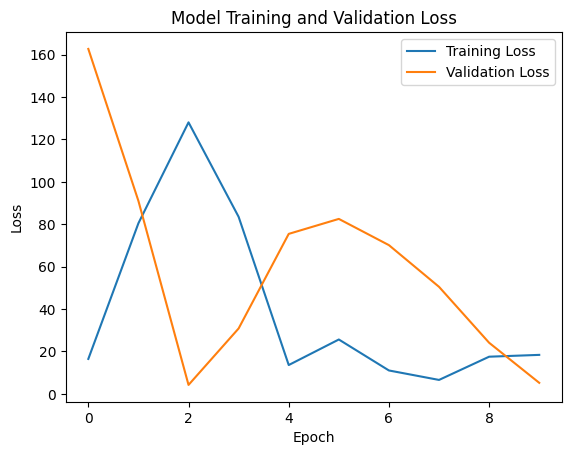

In [ ]:
# 학습 과정 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 정규화된 훈련 데이터를 원래 스케일로 되돌리기
def inverse_transform(y_pred, scaler):
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    return y_pred_rescaled

# 오차율 계산 함수
def calculate_error_rate(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE 계산


In [ ]:
# 모델을 사용하여 예측 수행
y_pred_padded = model.predict(X_test_padded)

1/1 [==============================] - 0s 90ms/step


In [ ]:
y_pred_padded

array([[[-0.02216617],
        [ 0.08950543],
        [-0.21481241],
        ...,
        [ 0.02574418],
        [ 0.02574418],
        [ 0.02574418]]], dtype=float32)

In [ ]:
y_test_padded

array([[0.82302168, 0.82302168, 0.82292511, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# 역변환


In [ ]:
# 오차율 계산
error_rate = calculate_error_rate(y_true_rescaled, y_pred_rescaled)
print(f'Error Rate: {error_rate:.2f}%')

NameError: name 'y_true_rescaled' is not defined

# **5. 모델 평가 및 선택**

**-성능 평가** : MAE, RMSE, MAPE 등의 지표를 사용하여 모델의 예측 성능을 평가합니다.

# **6. 예측 및 결과 해석**

**-미래 예측**: 최종 모델을 사용하여 미래 값에 대한 예측을 수행합니다.

**-결과 해석**: 예측 결과를 분석하고, 비즈니스 인사이트나 결정을 내리는 데 활용합니다.